# fashion mnist


In [4]:
import sys
import os
import random
import pickle
from tqdm.notebook import tqdm
from os.path import join

import struct
from array import array

import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader

from torchvision.transforms import transforms

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve

# Add the /root/src directory to sys.path
sys.path.append(os.path.abspath("../src"))
from utils.data_extraction import MNISTDataReader  # Replace with actual function name


In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# set seed for reproducibility
def set_seeds(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


Using device: cuda


## Loading in MNIST data

In [22]:
# # needed to download the data initially
# torchvision.datasets.CIFAR10(root='../data', train=True, download=True)
# torchvision.datasets.CIFAR10(root='../data', train=False, download=True)

# reading in data
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='latin1')
    return dict

x_train = []
y_train = []
for i in range(1,6):
    batch = unpickle(f'../data/cifar-10-batches-py/data_batch_{i}')
    x_train.append(batch["data"])
    y_train.append(batch["labels"])
x_train = np.concatenate(x_train)
y_train = np.concatenate(y_train)

test = unpickle('../data/cifar-10-batches-py/test_batch')
x_test = test["data"]
y_test = np.array(test["labels"])

# basic exploratory analysis

In [28]:
metadata = unpickle("../data/cifar-10-batches-py/batches.meta")
metadata["label_names"]

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

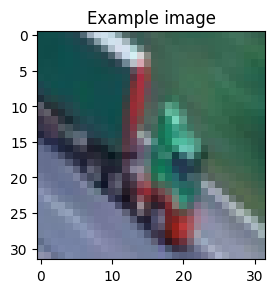

In [104]:
# basic exploratory analysis
def row_to_image(row):
    return row.reshape(3,32,32).transpose(1,2,0)

fig = plt.figure(figsize=(10, 3))

# plot example image
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("Example image")
ax1.imshow(row_to_image(x_train[50]));

# # plot distribtuion of input values
# ax2 = fig.add_subplot(1, 3, 2)
# ax2.set_title("Distribution of input values")
# ax2.scatter(*np.unique(x_train, return_counts=True));
# ax2.text(0.5, 0.5, f"Mean: {x_train.mean():.2f}, Std: {x_train.std():.2f}",
#          ha='center', va='center', transform=ax2.transAxes)
# ax2.text(0.5, 0.7, f"Mean when [0,1] {x_train.mean()/255:.2f}, Std {x_train.std()/255:.2f}",
#          ha='center', va='center', transform=ax2.transAxes)

# #plot distribution of labels
# ax3 = fig.add_subplot(1, 3, 3)
# ax3.set_title("Distribution of labels")
# ax3.hist(y_train);

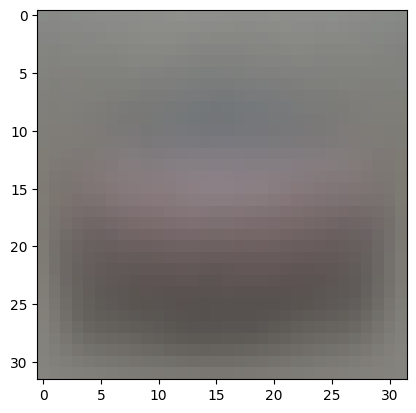

In [69]:
plt.imshow(row_to_image(x_train[y_train == 1].mean(axis=0)/255))

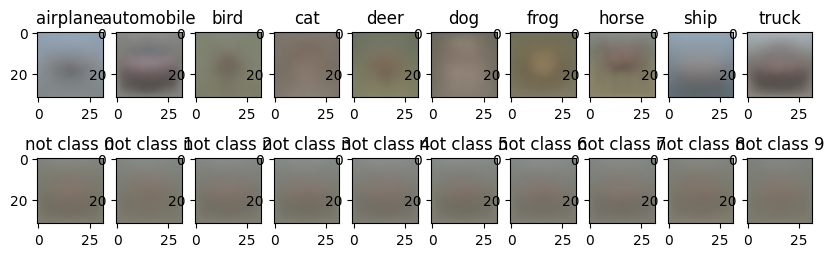

In [76]:
#visualize each class
fig = plt.figure(figsize = (10,3))

for i in range(0,10):
    ax1 = fig.add_subplot(2,10,i+1)
    ax1.imshow(row_to_image(x_train[y_train == i].mean(axis=0))/255)
    ax1.set_title(f"{metadata['label_names'][i]}")
    ax2 = fig.add_subplot(2,10,i+11)
    ax2.imshow(row_to_image(x_train[y_train != i].mean(axis=0))/255)
    ax2.set_title(f"not class {i}")
    # ax3 = fig.add_subplot(3,10,i+21)
    # ax3.imshow(row_to_image((x_train[y_train == i].mean(axis=0)) - (x_train[y_train != i].mean(axis=0)))/255)
    # ax3.set_title(f"class {i} - not {i}")

# creating dataset and loaders 

In [463]:
## define datasets 
class ImageDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data).reshape(-1,3,32,32) / 255 # will make it float32
        self.y_data = torch.tensor(y_data).to(torch.long) # will make it int64
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        # Convert numpy arrays to torch tensors
        x = self.x_data[idx] #dont want to squeeze here as we want to keep the [CxHxW] even if one 1 channel
        y = self.y_data[idx]
        return x, y


class FlatDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = torch.tensor(x_data) / 255 # will make it float32
        self.y_data = torch.tensor(y_data).to(torch.long) # will make it int64
        
    def __len__(self):
        return len(self.x_data)
    
    def __getitem__(self, idx):
        x = self.x_data[idx].view(1,-1).squeeze() 
        y = self.y_data[idx]
        return x, y


# Create datset and dataloader
image_train_dataset = ImageDataset(x_train, y_train)
image_train_dataloader = DataLoader(image_train_dataset, batch_size=32, shuffle=True)
image_test_dataset = ImageDataset(x_test, y_test)
image_test_dataloader = DataLoader(image_test_dataset, batch_size=32, shuffle=False)

flat_train_dataset = FlatDataset(x_train, y_train)
flat_train_dataloader = DataLoader(flat_train_dataset, batch_size=32, shuffle=True)
flat_test_dataset = FlatDataset(x_test, y_test)
flat_test_dataloader = DataLoader(flat_test_dataset, batch_size=32, shuffle=False)


Define the models - 
1. Logistic regression
2. FCNN
3. very basic CNN
4. CNN based on efficient net paper

# Metric definition

In [89]:
def classification_metrics(predictions,labels):
    outputs = {
        "Accuracy":(predictions == labels).mean()
    }
    print(outputs)
    return outputs

# logistic regression baseline

In [105]:
# simple logistic regression model
logregmodel = LogisticRegression(max_iter=100)
logregmodel.fit(x_train, y_train)

c:\Users\bruno\miniconda3\envs\cards\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [106]:
x_test_flat = x_test.reshape(x_test.shape[0],-1)
classification_metrics(logregmodel.predict(x_test_flat),y_test)

{'Accuracy': 0.4024}


{'Accuracy': 0.4024}

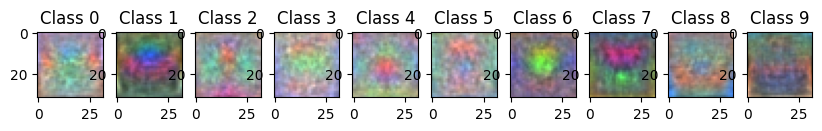

In [415]:
fig = plt.figure(figsize=(10,3))
for i in range(10):
    ax = fig.add_subplot(1,10,i+1)
    temp = torch.softmax(torch.tensor(logregmodel.coef_[i] / logregmodel.coef_.max()).view(3,-1),dim=1)
    temp = temp / temp.max()
    ax.imshow(row_to_image(temp.view(1,-1).numpy()))
    ax.set_title(f"Class {i}")

# Deep learning models

In [467]:
def train_one_epoch(model=None, 
                    optimizer=None, 
                    loss_fn=None, 
                    dataloader=None, 
                    verbose=False) -> tuple:
    '''
    1 epoch cycle of training for a general nn model
    '''
    train_loss = []
    dataloader_ = tqdm(dataloader,leave=False) if verbose else dataloader
    for batch_x, batch_y in dataloader_:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device) # move intputs to GPU

        optimizer.zero_grad()
        output = model(batch_x)
        loss = loss_fn(output, batch_y)
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    if verbose: dataloader_.close()
    
    # validation loop
    with torch.no_grad():
        val_loss = []
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device) # move intputs to GPU
            
            output = model(batch_x)
            loss = loss_fn(output, batch_y)

            val_loss.append(loss.item())
    return train_loss, val_loss

# Multilayer Perceptron

In [465]:
# Multilayer Perceptron
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(32*32*3, 10)

    def forward(self, x):
        x = self.fc1(x) 
        return x

In [468]:
mlp_model = MLP().to(device)
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in tqdm(range(5)):
    # training loop
    train_loss, val_loss = train_one_epoch(model = mlp_model,
                                           optimizer = optimizer,
                                           loss_fn = loss_fn,
                                           dataloader = flat_train_dataloader,
                                           verbose = True)

    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    tqdm.write(f"Epoch {epoch} train_loss: {np.mean(train_loss):.4} val_loss: {np.mean(val_loss):.4}")

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 0 train_loss: 1.956 val_loss: 1.993


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1 train_loss: 1.875 val_loss: 1.812


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2 train_loss: 1.86 val_loss: 1.856


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3 train_loss: 1.837 val_loss: 1.841


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4 train_loss: 1.841 val_loss: 1.774


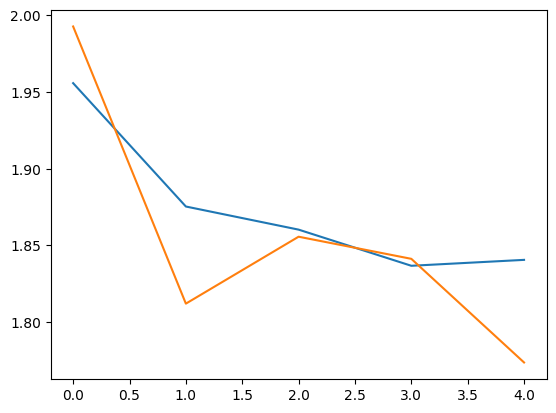

In [469]:
plt.plot(np.array(train_losses).mean(axis = 1))
plt.plot(np.array(val_losses).mean(axis = 1))

In [486]:
def prediction_helper(model,dataloader):
    predictions = []
    with torch.no_grad():
        for batch_x, batch_y in dataloader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            output = model(batch_x)
            predictions.append(output.argmax(dim=1).detach().cpu().numpy())
    predictions = np.concatenate(predictions)
    return predictions

def classification_metrics(predictions,labels):
    outputs = {
        "Accuracy":(predictions == labels).mean()
    }
    print(outputs)
    return outputs

predictions = prediction_helper(mlp_model,flat_test_dataloader)
classification_metrics(predictions,y_test);


{'Accuracy': 0.3517}


In [487]:
predictions

array([3, 9, 8, ..., 5, 5, 4], dtype=int64)

# Convolutional Neural Networks

## Basic CNN 

In [481]:
#define a basic CNN
class BasicCNN(nn.Module):
    def __init__(self,kernel_size=3,stride=1,padding=1):
        super(BasicCNN, self).__init__()
        # inputs are [3, 32, 32]
        # defaults are kernel_size=3, stride=1, padding=1
        # output is [32, 32+2*padding-kernel_size+1, 32+2*padding-kernel_size+1]
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels=32, kernel_size=kernel_size, stride=stride, padding=padding) # [3, 32, 32] -> [32, 32, 32]
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) # [32, 32, 32] -> [32, 16, 16] 
        self.relu = nn.ReLU() # [32, 16, 16] -> [32, 16, 16]
        self.flatten = nn.Flatten() # [32, 16, 16] -> [32*16*16] ([6272])
        self.fc1 = nn.Linear(32*16*16, 10) # [8192] -> [10] #output classes

    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc1(x)
        return x

In [478]:
next(iter(image_train_dataloader))[0].shape

torch.Size([32, 3, 32, 32])

In [484]:
basic_cnn_model = BasicCNN().to(device)
basic_cnn_optimizer = optim.Adam(basic_cnn_model.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()

train_losses = []
val_losses = []

for epoch in range(5):
    train_loss, val_loss = train_one_epoch(model = basic_cnn_model,
                                           optimizer = basic_cnn_optimizer,
                                           loss_fn = loss_fn,
                                           dataloader = image_train_dataloader,
                                           verbose = True)

    train_losses.append(train_loss)
    val_losses.append(val_loss)    
    print(f"Epoch {epoch} train_loss: {np.mean(train_loss):.4} val_loss: {np.mean(val_loss):.4}")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 0 train_loss: 1.455 val_loss: 1.19


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 1 train_loss: 1.18 val_loss: 1.108


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 2 train_loss: 1.078 val_loss: 0.949


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 3 train_loss: 1.005 val_loss: 0.907


  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch 4 train_loss: 0.9521 val_loss: 0.891


In [489]:
cnn_predictions = prediction_helper(basic_cnn_model,image_test_dataloader)
classification_metrics(cnn_predictions,y_test);

{'Accuracy': 0.6208}


In [514]:
kernels = [i for i in basic_cnn_model.conv1.named_parameters() if i[0] == "weight"][0][1]
kernels = kernels.view(32,3,9).softmax(dim=2).view(32,3,3,3).detach().cpu().numpy()
kernels[0].shape


(3, 3, 3)

In [517]:
kernels

array([[[[0.09513968, 0.11787864, 0.09472957],
         [0.1163776 , 0.13113229, 0.11680988],
         [0.10448843, 0.11052985, 0.10392196]],

        [[0.1468226 , 0.14362502, 0.10418336],
         [0.1423543 , 0.10815955, 0.0997837 ],
         [0.14559926, 0.12708972, 0.12701656]],

        [[0.11120029, 0.08901817, 0.09740266],
         [0.09957528, 0.1080203 , 0.07778711],
         [0.0948213 , 0.09614915, 0.09038376]]],


       [[[0.13061257, 0.1284    , 0.10271711],
         [0.10065882, 0.10712383, 0.12232538],
         [0.08845355, 0.11274455, 0.0883451 ]],

        [[0.1063863 , 0.10548922, 0.09044194],
         [0.10359509, 0.10389706, 0.1269489 ],
         [0.12123202, 0.12843925, 0.12448459]],

        [[0.10103592, 0.12097399, 0.11394297],
         [0.11872463, 0.10362138, 0.11310495],
         [0.09680092, 0.12107262, 0.11842739]]],


       [[[0.13092643, 0.11175179, 0.11147358],
         [0.11207595, 0.12769544, 0.09517425],
         [0.11276326, 0.0941215 , 0.10895575

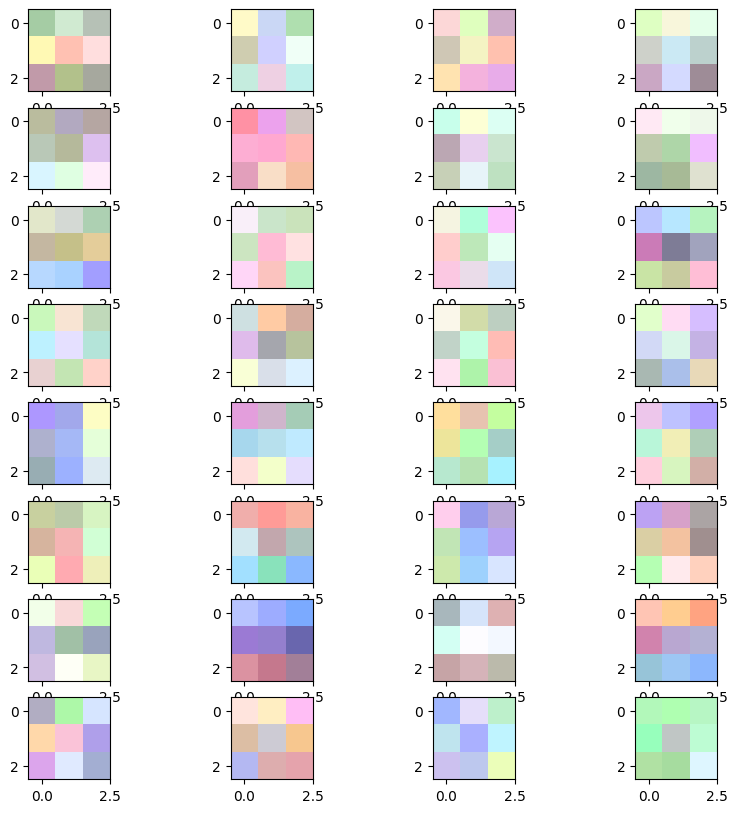

In [550]:
kernels = [i for i in basic_cnn_model.conv1.named_parameters() if i[0] == "weight"][0][1]
kernels_flat = kernels.view(32,3,9).softmax(dim=2)
kernels_flat = kernels_flat / kernels_flat.max(dim=2).values.unsqueeze(2).repeat(1,1,9)
kernels = kernels_flat.view(32,3,3,3).permute(0,3,1,2).detach().cpu().numpy()
len(kernels)
fig = plt.figure(figsize = (10,10))
for i,x in enumerate(kernels):
    ax = fig.add_subplot(8,32//8,i+1)
    ax.imshow(x)
